In [136]:
import sys
sys.path.insert(0,'..')

# Compute Embeddings 

In [135]:
import pandas as pd
from src import embeddings

df = pd.read_csv('../output/armando_with_all_features_test_prediction.csv')

In [67]:
DIM_Y = df['test_id'].value_counts().max()

In [137]:
SEP_TOKEN = '<SEP>'
test_ids = df['test_id'].unique()

df['picked'] = df['picked'].astype('string')
test_df = df.groupby(['test_id'], as_index=False).aggregate({'headline': SEP_TOKEN.join, 'picked':SEP_TOKEN.join})
test_df

,test_id,headline,picked
0,5143605e220cb80002000076,"Hey Dude. If You Have An Older Brother, There'...",0<SEP>0<SEP>0<SEP>0<SEP>1
1,51436060220cb800020001e1,There Is Quicksand All Over Manhattan<SEP>'Get...,0<SEP>0<SEP>0<SEP>1
2,51436060220cb800020001e3,Thousands Of Protesters Are About To Descend O...,1<SEP>0<SEP>0<SEP>0
3,51436061220cb800020001e4,3 Things You Can Do Instead Of Watching TV<SEP...,1<SEP>0<SEP>0<SEP>0
4,51436061220cb800020001e7,Creationism Has Nothing To Do With Christianit...,0<SEP>1<SEP>0<SEP>0
...,...,...,...
14636,55413048643265002c840200,Pope Francis says it's 'pure scandal' that wom...,0<SEP>0<SEP>1<SEP>0<SEP>0
14637,5541323d643265002cbc0200,Being addicted to a particular drug should not...,0<SEP>0<SEP>0<SEP>1<SEP>0
14638,5541358d643933000c3c0300,How a neurological condition led to one artist...,0<SEP>0<SEP>1<SEP>0<SEP>0
14639,55413ef4333531000c180000,They spent 4 days in the swamp looking for a c...,1<SEP>0


In [138]:
import pickle
import numpy as np

hle_fname = '../output/hl_embeddings_test_prediction.pkl'
hl_embeddings = pickle.load(open(hle_fname, "rb"))
hl_embeddings = np.array(hl_embeddings)
hl_embeddings.shape

(66972, 384)

In [139]:
from src import embeddings
blank_embedding = embeddings.bert([''])[0]

INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
INFO:sentence_transformers.SentenceTransformer:Use pytorch device: cpu


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [140]:
ner_keys = ['LOC', 'PERSON', 'WORK_OF_ART','LANGUAGE','PRODUCT','QUANTITY','DATE','CARDINAL','GPE','TIME','ORG','LAW','MONEY','FAC','EVENT','PERCENT','NORP','ORDINAL']
ner_cols = [f'{k}_start' for k in ner_keys] + [f'{k}_end' for k in ner_keys]
other_features = ['hl_len', 'neg', 'neu', 'pos'] + ner_cols
df[other_features]

other_embeddings = df[other_features].to_numpy()

In [143]:
other_embeddings

array([[8.90000000e+01, 1.22290142e-02, 8.39928269e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [8.20000000e+01, 1.88391993e-03, 7.45916069e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [9.20000000e+01, 7.81922996e-01, 2.13357523e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [8.30000000e+01, 9.83206391e-01, 1.29922926e-02, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [8.00000000e+01, 9.85054851e-01, 9.63695347e-03, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [6.10000000e+01, 9.84386027e-01, 1.09683834e-02, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [142]:
def complete_list(l, to, val):
    init_len = len(l)
    for i in range(init_len, to):
        l.append(val)
    return l

def get_embedding(hl):
    global hl_embeddings, df, blank_embedding
    if not hl:
        return blank_embedding
    hl_idx = df.index[df['headline'] == hl].tolist()[0]
    return np.concatenate(hl_embeddings[hl_idx], other_embeddings[hl_idx])


def create_sample(headline, picked):
    global DIM_Y
    headline = complete_list(headline.split(SEP_TOKEN), DIM_Y, '')
    picked = complete_list(picked.split(SEP_TOKEN), DIM_Y, '0')
    headline = np.concatenate(tuple(get_embedding(hl) for hl in headline))
    picked = np.array([int(p) for p in picked])
    return headline, picked

tdf = test_df

test_dict = {test_id: (headline, picked) for test_id, headline, picked in zip(tdf['test_id'], tdf['headline'], tdf['picked'])}
test_dict = {k: create_sample(*v) for k, v in test_dict.items()}
test_dict

TypeError: only integer scalar arrays can be converted to a scalar index

In [92]:
# storing embeddings
# pickle.dump(test_dict, open('../output/test_dict.pkl', "wb"))

In [93]:
X, y = tuple(zip(*test_dict.values()))
X, y = np.array(X), np.array(y)

In [111]:
y = np.array([np.where(r==1)[0][0] for r in y])

In [112]:
X.shape, y.shape

((14641, 6528), (14641,))

# Predict 

In [116]:
import torch
from sklearn.preprocessing import StandardScaler
from torch import nn
from torch.utils.data import DataLoader

class PackagesDataset(torch.utils.data.Dataset):
    """
    Prepare the Packages dataset for regression
    """

    def __init__(self, X, y, scale_data=True):
        if not torch.is_tensor(X) and not torch.is_tensor(y):
            # Apply scaling if necessary
            if scale_data:
                X = StandardScaler().fit_transform(X)
            self.X = torch.from_numpy(X)
            self.y = torch.from_numpy(y).type(torch.LongTensor)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]


class MLP(nn.Module):
    """
      Multilayer Perceptron for classification.
    """

    def __init__(self, in_size):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(in_size, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, DIM_Y)
        )

    def forward(self, x):
        """
          Forward pass
        """
        return self.layers(x)

In [130]:
NB_EPOCHS = 15
# Set fixed random number seed
torch.manual_seed(42)

# Load Packages dataset
# X, y = load_packages()

# Prepare Packages dataset
dataset = PackagesDataset(X, y)

# Split Packages dataset
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# Create trainloader object
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=1)

# Create testloader object
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=256, shuffle=True, num_workers=1)

# Initialize the MLP
mlp = MLP(in_size=X.shape[1])

# Define the loss function and optimizer
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mlp.parameters(), lr=1e-4)


losses = {'train': [], 'test': []}
accuracies = {'train': [], 'test': []}
epochs = range(NB_EPOCHS)


def train(epoch):
     # Print epoch
    print(f'Starting epoch {epoch + 1}')

    mlp.train()
    
    # Set current loss value
    current_loss = 0.0
    correct=0
    total=0

    # Iterate over the DataLoader for training data
    for i, data in enumerate(trainloader, 0):

        # Get and prepare inputs
        inputs, targets = data
        inputs, targets = inputs.float(), targets.float()
        # targets = targets.reshape((targets.shape[0], 1))

        # Zero the gradients
        optimizer.zero_grad()

        # Perform forward pass
        outputs = mlp(inputs)

        # Compute loss
        loss = loss_function(outputs, targets.type(torch.LongTensor))

        # Perform backward pass
        loss.backward()

        # Perform optimization
        optimizer.step()

        # Update Loss
        current_loss += loss.item()
        
        # Update Accuracy
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        
    
    current_loss /= len(trainloader)
    current_accuracy=100.*correct/total
    
    print(f'Train: {correct, total}')
    
    losses['train'].append(current_loss)
    accuracies['train'].append(current_accuracy)
    
    print('Train Loss: %.3f | Accuracy: %.3f'%(current_loss, current_accuracy))

    
def test(epoch):
    mlp.eval()

    # Set current loss value
    current_loss = 0.0
    correct=0
    total=0

    # Iterate over the DataLoader for training data
    for i, data in enumerate(testloader, 0):

        # Get and prepare inputs
        inputs, targets = data
        inputs, targets = inputs.float(), targets.float()
        # targets = targets.reshape((targets.shape[0], 1))

        # Perform forward pass
        outputs = mlp(inputs)

        # Compute loss
        loss = loss_function(outputs, targets.type(torch.LongTensor))

        # Update Loss
        current_loss += loss.item()
        
        # Update Accuracy
        _, predicted = outputs.max(1)
        
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    
    current_loss /= len(testloader)
    current_accuracy=100.*correct/total
    print(f'Test: {correct, total}')
    
    losses['test'].append(current_loss)
    accuracies['test'].append(current_accuracy)
    
    print('Test %.3f | Accuracy: %.3f'%(current_loss, current_accuracy))

# Run the training loop
for epoch in epochs:
    train(epoch)
    test(epoch)

Starting epoch 1
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Train: (1721, 11712)
Train Loss: 2.728 | Accuracy: 14.694
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Test: (708, 2929)
Test 2.615 | Accuracy: 24.172
Starting epoch 2
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizer

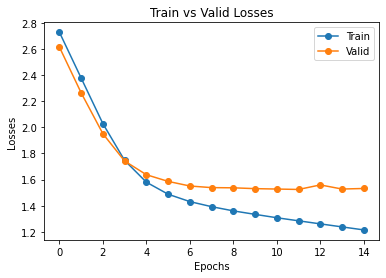

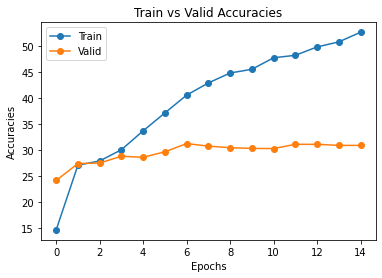

In [134]:
import matplotlib.pyplot as plt

plt.plot(losses['train'], '-o')
plt.plot(losses['test'], '-o')
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Losses')
 
plt.show()

#

plt.plot(accuracies['train'], '-o')
plt.plot(accuracies['test'], '-o')
plt.xlabel('Epochs')
plt.ylabel('Accuracies')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Accuracies')
 
plt.show()

In [129]:
losses['test'].index(min(losses['test']))

11

# Examples

In [17]:
torch.save(mlp.state_dict(), '../output/mlp_test_prediction_100_epochs.pt')

In [23]:
targets.size(0)

NameError: name 'targets' is not defined